In [1]:
import pandas as pd
import numpy as np

In [2]:
survey = pd.read_csv("./data/survey_fp_base.csv")#, nrows=30)

In [3]:
survey.loc[survey.heatexp == 9999, "heatexp"] = np.nan
survey.loc[survey.heatexp == -5, "heatexp"] = np.nan
survey.loc[survey.heatexp == -1, "heatexp"] = np.nan

In [4]:
survey.hhsize = survey.hhsize.astype("category")
survey.hhsize.cat.categories = [1, 2, 3, 4, 5, 6]
survey.hhsize = survey.hhsize.astype(int)

In [5]:
survey.loc[:, "selection"] = 0

# Create sampling ranks

## (1) Construction year

In [6]:
sum_inx = (survey.bja == 'Pre.1919')     | \
          (survey.bja == 'X1919...1948')
survey.loc[sum_inx, "selection"] += 1 

In [7]:
sub_inx = (survey.bja == 'X1987...1990')   | \
          (survey.bja == 'X1991...2000')   | \
          (survey.bja == 'X2001...2004')   | \
          (survey.bja == 'X2005...2008')   | \
          (survey.bja == 'X2009.and.later')
survey.loc[sub_inx, "selection"] -= 1 

## (2) Resident's age

In [8]:
sub_inx = (survey.age == 'X50...64') |\
          (survey.age == 'X30...49')
survey.loc[sub_inx, "selection"] += 1

In [9]:
sub_inx = (survey.age == 'X65.and.over')
survey.loc[sub_inx, "selection"] -= 1

## (3) Ownwership

In [10]:
survey.loc[survey.ownership == 1, "selection"] += 1

In [11]:
survey.loc[survey.ownership >= 3, "selection"] -= 1

## (4) Heat expenditure

In [12]:
mean_heatexp = survey.heatexp.mul(survey.wt.div(survey.wt.sum())).sum()

In [13]:
survey.loc[survey.heatexp > mean_heatexp, "selection"] += 1

In [14]:
survey.loc[survey.heatexp < mean_heatexp, "selection"] -= 1

## (5) Building size

In [15]:
survey.loc[survey.bsize == 1, "selection"] += 1

In [16]:
survey.loc[survey.bsize >= 3, "selection"] -= 1

## (6) Fuel

In [17]:
sum_inx = (survey.fuel == 'BlackCoal')   | \
          (survey.fuel == 'BrownCoal')   | \
          (survey.fuel == 'Electricity') | \
          (survey.fuel == 'HeatingOil')
survey.loc[sum_inx, "selection"] += 1

In [18]:
sum_inx = (survey.fuel == 'Biogas')         | \
          (survey.fuel == 'HeatPump.mean')  | \
          (survey.fuel == 'SolarEnergie')   | \
          (survey.fuel == 'Wood')
survey.loc[sum_inx, "selection"] -= 1

# Sample retrofits

In [19]:
import matplotlib.pylab as plt
import matplotlib
matplotlib.pyplot.style.use('seaborn-deep')
%matplotlib inline

## (1) Retrofits

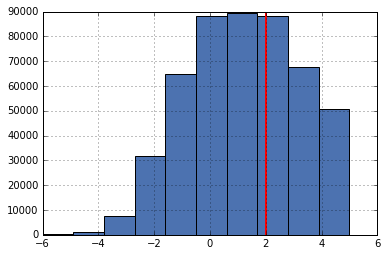

In [20]:
fig, ax = plt.subplots()
survey.selection.hist(ax=ax);
ax.axvline(x=2, linewidth=2, color = 'r')
fig.savefig("FIGURES/hist_sel.png", bbox_inches="tight");

In [21]:
du = survey.wt.div(survey.hhsize).sum()

In [30]:
print("Retrofit {:0.2f}%".format(
    survey.loc[survey.selection >= 2, "wt"].div(survey.loc[survey.selection >= 2, "hhsize"]).sum() / du * 100))

Retrofit 38.61%


In [23]:
new_survey_s1 = survey.copy()
new_survey_s1.loc[new_survey_s1.selection >= 2, "fuel"] = "SolarEnergie"
new_survey_s1.loc[new_survey_s1.selection >= 2, "bja"] = "X2009.and.later"
new_survey_s1.to_csv("./data/survey_fp_s1.csv", index=False)

## (2) Grid

In [31]:
grid_inx = (survey.fuel == "Electricity")|\
           (survey.fuel == "DistrictHeating.mean")
print("Retrofit {:0.2f}%".format(
    survey.loc[grid_inx, "wt"].div(survey.loc[grid_inx, "hhsize"]).sum() / du * 100))

Retrofit 16.59%


In [25]:
new_survey_grid = survey.copy()
new_survey_grid.loc[new_survey_grid.fuel == "Electricity", "fuel"] = "Biogas"
new_survey_grid.loc[new_survey_grid.fuel == "DistrictHeating.mean", "fuel"] = "SolarEnergie"
new_survey_grid.to_csv("./data/survey_fp_s2.csv", index=False)

## (3) Retrofits + Grid

In [32]:
grid_inx = (survey.fuel == "Electricity")|\
           (survey.fuel == "DistrictHeating.mean") | \
           (survey.selection >= 2)
print("Retrofit {:0.2f}%".format(
    survey.loc[grid_inx, "wt"].div(survey.loc[grid_inx, "hhsize"]).sum() / du * 100))

Retrofit 51.76%


In [27]:
new_survey_both = survey.copy()
new_survey_both.loc[new_survey_both.selection >= 2, "bja"] = "X2009.and.later"
new_survey_both.loc[new_survey_both.fuel == "Electricity", "fuel"] = "Biogas"
new_survey_both.loc[new_survey_both.fuel == "DistrictHeating.mean", "fuel"] = "SolarEnergie"
new_survey_both.loc[new_survey_both.selection >= 2, "fuel"] = "SolarEnergie"
new_survey_both.to_csv("./data/survey_fp_s3.csv", index=False)